# PCA for Source Separation of Ventilation and Cardiovascular Activity in Electrical Impedance Tomography (EIT)

## Introduction
In this exercise we use PCA for processing image sequences of thoracic electrical impedance tomography (EIT) signals. EIT is a non-invasive, radiation-free imaging modality which uses small alternating currents to measure bioimpedance of the thorax [1]. These measurements are then converted into image sequences of thoracic impedance changes representing ventilation (i.e., air exchange in the lungs) and cardiovascular activity (e.g., heart movement or blood volume changes in heart and lungs). 

In order to analyze these data it is important to properly separate ventilation and cardiovascular activity. Besides common techniques such as frequency filtering or ECG-triggered averaging, PCA can be used for separating these two sources of signals.
The present example uses the method proposed by Deibele et al. [2] for which the block diagram is shown below:

<img src="FlowChart_Deibele.png">


## References

[1] I. Frerichs et al., “Chest electrical impedance tomography examination, data analysis, terminology, clinical use and recommendations: consensus statement of the TRanslational EIT developmeNt stuDy group,” Thorax, vol. 72, no. 1, pp. 83–93, Jan. 2017, doi: [10.1136/thoraxjnl-2016-208357](https://dx.doi.org/10.1136/thoraxjnl-2016-208357).

[2] J. M. Deibele, H. Luepschen, and S. Leonhardt, “Dynamic separation of pulmonary and cardiac changes in electrical impedance tomography,” Physiological Measurement, vol. 29, no. 6, pp. S1–S14, Jun. 2008, doi: [10.1088/0967-3334/29/6/S01](https://dx.doi.org/10.1088/0967-3334/29/6/S01).

In [63]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import filtfilt, butter
from scipy.linalg import eigh

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)  # initiate notebook for offline plot

from ecgdetectors import Detectors

In [64]:
# load data
data = loadmat('EIT_Data.mat')
t = data['tEit'].flatten()[data['IdxRange'].flatten().astype(bool)]
fs = 1/np.median(np.diff(t))
imgs_eit = data['Imgs']
b, a = butter(4, np.asarray([0.1, 12]), fs=fs, btype='bandpass')
imgs_eit = filtfilt(b, a, imgs_eit, axis=-1)
imgs_eit *= 1E3  # adapt scaling for plotting

# ECG data to be used for bonus question
ecg = {'time': data['Ecg'][0][0][2], 'value': data['Ecg'][0][0][1], 'fs': data['Ecg'][0][0][3]}
ecg_range = (ecg['time'] > t[0]) & (ecg['time'] < t[-1])
ecg['time'] = ecg['time'][ecg_range]
ecg['value'] = ecg['value'][ecg_range]

# force all timings to start at zero
t -= t[0]
ecg['time'] -= ecg['time'][0]

In [65]:
# plot input data
fig = make_subplots(rows=1, cols=2, column_widths=[1, 2])
fig.update_layout(width=950, height=400)

fig.add_trace(go.Heatmap(z=np.std(imgs_eit, axis=-1), zmin=0, 
                         showscale=False, colorscale='magma'), row=1, col=1)
fig.update_yaxes(title='Right', showticklabels=False, autorange="reversed", row=1, col=1)
fig.update_xaxes(title='Dorsal', showticklabels=False, row=1, col=1)
fig.update_layout(title='Overall EIT Activity')

fig.add_trace(go.Scatter(x=t, y=np.nansum(imgs_eit, axis=(0, 1)), 
                         name='Overall Sum Signal', line_color='black'), row=1, col=2)
fig.update_xaxes(title='Time (s)', row=1, col=2)
fig.update_yaxes(title='Impedance Change \Delta Z (A.U.)', row=1, col=2)


<>:14: SyntaxWarning:

invalid escape sequence '\D'

<>:14: SyntaxWarning:

invalid escape sequence '\D'

C:\Users\goali\AppData\Local\Temp\ipykernel_58008\8286992.py:14: SyntaxWarning:

invalid escape sequence '\D'



In [66]:
def compute_principal_components(X):
    # perform PCA and compute principal components (pc) and eigenvalues of X
    A = np.dot(X.transpose(), X)  # covariance matrix
    [eigenvalues, eigenvectors] = eigh(A)
    pc = np.dot(X, eigenvectors)
    return pc, eigenvalues

def estimate_cardiac_frequency(s, fs):
    sign_cardiac = np.sign(s)
    # find where zero crossings occured
    index = np.where(np.diff(sign_cardiac) == 2)[0]
    # interpolate to a sub-sample resolution
    pos = index + s[index + 1] / (s[index + 1] - s[index])
    # interpolate RR interval values
    rr = np.diff(pos) / fs
    return 1/np.median(rr)

def lms(A, B):
    if B.ndim == 1:
        B = np.asmatrix(B).transpose()
    tmp = np.linalg.solve(np.dot(B.transpose(), B), B.transpose())
    return np.dot(np.dot(B, tmp), A)

# separate ventilation and cardiovascular activity using PCA
# according to the algorithm by Deibele et al., PhysMeas, 2008
# https://dx.doi.org/10.1088/0967-3334/29/6/S01
imgs_tmp = np.reshape(imgs_eit, [-1, imgs_eit.shape[-1]])
are_valid_pixels = np.all(~np.isnan(imgs_tmp), 1)
X = imgs_tmp[are_valid_pixels, :].transpose()

# first approximation (see block diagram)
X = X - np.repeat(np.reshape(np.mean(X, 0), [1, -1]), X.shape[0], 0)
PC1, lambda1 = compute_principal_components(X)
Bv = PC1[:, -1]
Xv_ = lms(X, Bv)
Xc_ = X - Xv_

# second approximation (see block diagram)
Xc_ = Xc_ - np.repeat(np.reshape(np.mean(Xc_, 0), [1, -1]), Xc_.shape[0], 0)
b, a = butter(6, np.asarray([0.92, 4.6]), fs=fs, btype='bandpass')
Xc_bp = filtfilt(b, a, Xc_, axis=0)
PC2, lambda2 = compute_principal_components(Xc_bp)
Bc_ = PC2[:, -2:]
fc = estimate_cardiac_frequency(Bc_[:, 0], fs)

# create cardiac template functions
Bc = np.hstack((Bc_, np.roll(Bc_, int(fs/fc/3), 0),
                np.roll(Bc_, -int(fs/fc/3), 0)))
Xc1 = lms(Xc_, Bc)
Xc2 = lms(Xv_, Bc)
Xc = (Xc1 + Xc2).transpose()
Xv = (Xv_ - Xc2).transpose()

# cardiovascular activity
imgs_card = np.full(imgs_tmp.shape, np.nan)
imgs_card[are_valid_pixels, :] = Xc
imgs_card = imgs_card.reshape(imgs_eit.shape)
# ventilation activity
imgs_vent = np.full(imgs_tmp.shape, np.nan)
imgs_vent[are_valid_pixels, :] = Xv
imgs_vent = imgs_vent.reshape(imgs_eit.shape)

In [68]:
# plot ventilation acticity
fig = make_subplots(rows=1, cols=2, column_widths=[1, 2])
fig.update_layout(width=950, height=400)

fig.add_trace(go.Heatmap(z=np.std(imgs_vent, axis=-1), zmin=0, 
                         showscale=False, colorscale='magma'), row=1, col=1)
fig.update_yaxes(title='Right', showticklabels=False, autorange="reversed", row=1, col=1)
fig.update_xaxes(title='Dorsal', showticklabels=False, row=1, col=1)
fig.update_layout(title='Ventilation Activity')

fig.add_trace(go.Scatter(x=t, y=np.nanmean(imgs_vent, axis=(0, 1)), 
                         name='Mean Signal', line_color='black'), row=1, col=2)
fig.update_xaxes(title='Time (s)', row=1, col=2)
fig.update_yaxes(title='Impedance Change \Delta Z (A.U.)', row=1, col=2)

# add example signals in ??? regions
regions = {'Region RL': ([10, 14], 'magenta'), 'Region LL': ([22, 14], 'orange')}
for reg, tmp in regions.items():
    fig.add_scatter(x=[tmp[0][0]], y=[tmp[0][1]], mode='markers', marker_symbol='square-open', 
                    marker_size=10, legendgroup=reg, marker_color=tmp[1], name=reg, row=1, col=1)
    fig.add_trace(go.Scatter(x=t, y=imgs_vent[tmp[0][1], tmp[0][0], :], legendgroup=reg, 
                             showlegend=False, name=reg, line_color=tmp[1]), row=1, col=2) 
    
fig.show()

<>:14: SyntaxWarning:

invalid escape sequence '\D'

<>:14: SyntaxWarning:

invalid escape sequence '\D'

C:\Users\goali\AppData\Local\Temp\ipykernel_58008\585298053.py:14: SyntaxWarning:

invalid escape sequence '\D'



In [69]:
# plot cardiovascular acticity
fig = make_subplots(rows=1, cols=2, column_widths=[1, 2])
fig.update_layout(width=950, height=400)

fig.add_trace(go.Heatmap(z=np.std(imgs_card, axis=-1), zmin=0, 
                         showscale=False, colorscale='magma'), row=1, col=1)
fig.update_yaxes(title='Right', showticklabels=False, autorange="reversed", row=1, col=1)
fig.update_xaxes(title='Dorsal', showticklabels=False, row=1, col=1)
fig.update_layout(title='Cardiovascular Activity')

fig.add_trace(go.Scatter(x=t, y=np.nanmean(imgs_card, axis=(0, 1)), 
                         name='Mean Signal', line_color='black'), row=1, col=2)
fig.update_xaxes(title='Time (s)', row=1, col=2)
fig.update_yaxes(title='Impedance Change \Delta Z (A.U.)', row=1, col=2)

# add three example signals in ??? regions
regions = {'Region A': ([18, 9], 'green'), 'Region B': ([10, 15], 'blue'), 'Region C': ([23, 15], 'red')}
for reg, tmp in regions.items():
    fig.add_scatter(x=[tmp[0][0]], y=[tmp[0][1]], mode='markers', marker_symbol='square-open', 
                    marker_size=10, legendgroup=reg, marker_color=tmp[1], name=reg, row=1, col=1)
    fig.add_trace(go.Scatter(x=t, y=imgs_card[tmp[0][1], tmp[0][0], :], legendgroup=reg, 
                             showlegend=False, name=reg, line_color=tmp[1]), row=1, col=2)    
fig.show()

<>:14: SyntaxWarning:

invalid escape sequence '\D'

<>:14: SyntaxWarning:

invalid escape sequence '\D'

C:\Users\goali\AppData\Local\Temp\ipykernel_58008\500177849.py:14: SyntaxWarning:

invalid escape sequence '\D'



# Exercise Questions
Please provide your answers directly below each question.

---

## Question 1 
Determine the frequency of the ventilation activity (i.e., the respiratory rate), both expressed in `Hz` and `respirations/min`.

In [70]:
vent_activity = np.nanmean(imgs_vent, axis=(0, 1))

from scipy.signal import find_peaks

vent_peaks, _ = find_peaks(vent_activity, distance=int(2*fs))

vent_peaks_t =  np.array(vent_peaks)/ fs
mean_resp_rate = np.mean(1 / np.diff(vent_peaks_t))

print('Mean ventilation frequency (respiratory rate): {:.2f} Hz'.format(mean_resp_rate))
print('Mean ventilation frequency (respiratory rate): {:.2f} respirations/min'.format(60*mean_resp_rate))

Mean ventilation frequency (respiratory rate): 0.33 Hz
Mean ventilation frequency (respiratory rate): 19.94 respirations/min


## Question 2
Determine the frequency of the cardiovascular activity, both expressed in `Hz` and `beats/min`.

In [71]:
card_activity = np.nanmean(imgs_card, axis=(0, 1))

card_peaks, _ = find_peaks(card_activity, distance=int(0.9*fs))
# The value of distance is set to 0.9*fs to avoid detecting multiple peaks 
# in the same cardiac cycle, and we verify the correctness of the detected peaks by visual inspection.

card_peaks_t =  np.array(card_peaks)/ fs
mean_card_freq = np.mean(1 / np.diff(card_peaks_t))

print('Mean cardiovascular frequency: {:.2f} Hz'.format(mean_card_freq))
print('Mean cardiovascular frequency: {:.2f} beats/min'.format(60*mean_card_freq))

Mean cardiovascular frequency: 0.97 Hz
Mean cardiovascular frequency: 58.03 beats/min


## Question 3
Determine the following three values:

- i) the maximal amplitude of ventilation activity; 
- ii) the maximal amplitude of cardiovascular activity; and 
- iii) the ratio between i) and ii), i.e., ventilation vs cardiovascular activity. 

In [80]:
max_amp_vent_activity = np.nanmax(vent_activity)
max_amp_card_activity = np.nanmax(card_activity)
ratio_ventilation_cardiovascular = max_amp_vent_activity / max_amp_card_activity
ratio_cardiovascular_ventilation = max_amp_card_activity / max_amp_vent_activity

print('i) Maximum amplitude of ventilation activity: {:.5f}'.format(max_amp_vent_activity))
print('ii) Maximum amplitude of cardiovascular activity: {:.5f}'.format(max_amp_card_activity))
print('iii) a) Ratio of ventilation to cardiovascular activity: {:.5f}'.format(ratio_ventilation_cardiovascular))
print('iii) b) Ratio of cardiovascular to ventilation activity: {:.5f}'.format(ratio_cardiovascular_ventilation))


i) Maximum amplitude of ventilation activity: 0.02816
ii) Maximum amplitude of cardiovascular activity: 0.00315
iii) a) Ratio of ventilation to cardiovascular activity: 8.93551
iii) b) Ratio of cardiovascular to ventilation activity: 0.11191


## Question 4
Determine the eigenvalues of the first three principal components resulting from the first PCA (see variable `PC1`).

In [ ]:
# Determine the eigenvalues of the first three principal components resulting from the first PCA (see variable `PC1`).
print('Eigenvalues of the first three principal components resulting from the first PCA:')
print(lambda1[-1], lambda1[-2], lambda1[-3])


Eigenvalues of the first three principal components resulting from the first PCA:
107.58688656183709 2.1114888816145285 0.8031524393717155


## Question 5
Similar to Question 4, determine the two most dominant frequencies for the first three principal components. <i>Note that this would lead to a total of 6 values, 2 frequencies for each of the 3 PCA components. However, for some components only one dominant frequency might be present.</i><br>
For all 3 PCA components, which one is rather related to ventilation or cardiovascular activity?

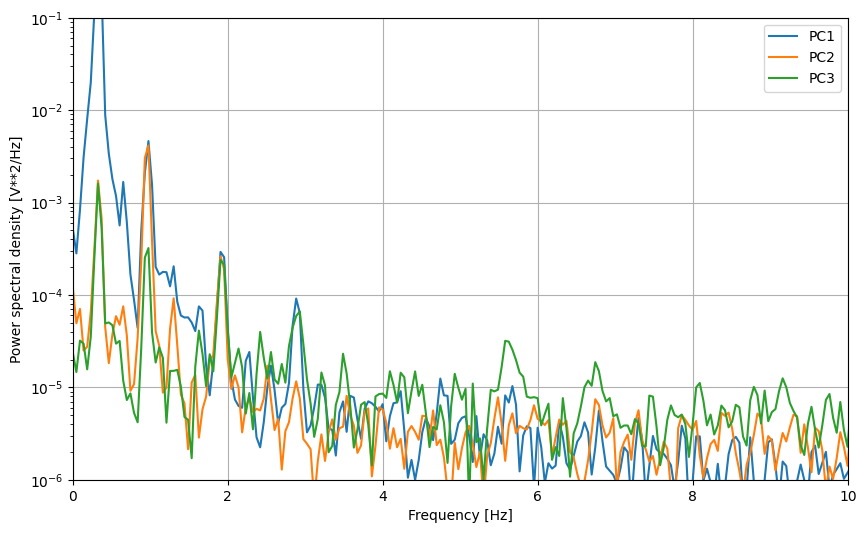

The values of the first three principal components resulting from the first PCA:
[-0.12186629 -0.11530548 -0.13045841 ...  0.04332511  0.03668711
  0.03658657]
[ 0.01569289  0.08292314  0.08326825 ... -0.12283211 -0.1106632
 -0.01996051]
[ 0.00341983  0.03634772  0.03486044 ...  0.00031399 -0.001566
  0.00510862]


In [93]:
#Plot the power spectral density for the first three principal components resulting from the first PCA (see variable `PC1`).
import matplotlib.pyplot as plt
from scipy.signal import welch

f, Pxx = welch(PC1[:, -1], fs=fs, nperseg=1024)
plt.figure(figsize=(10, 6))
plt.semilogy(f, Pxx, label='PC1')
f, Pxx = welch(PC1[:, -2], fs=fs, nperseg=1024)
plt.semilogy(f, Pxx, label='PC2')
f, Pxx = welch(PC1[:, -3], fs=fs, nperseg=1024)
plt.semilogy(f, Pxx, label='PC3')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power spectral density [V**2/Hz]')
plt.legend()
plt.xlim([0, 10])
plt.ylim([1E-6, 1E-1])
plt.grid()
plt.show()

# Print the values 
print('The values of the first three principal components resulting from the first PCA:')
print(PC1[:, -1])
print(PC1[:, -2])
print(PC1[:, -3])



## Question 6
The three example signals (Regions A to C: **green, blue, red**) of cardiovascular activity show the impedance change over time. 
Can you guess the underlying anatomical structure for each of the three example signals (Regions A to C: **green, blue, red**).

## Question 7 - *Bonus Question* (not graded) 
Can you detect the QRS peaks (e.g., using [`qrs = Detectors(fs).engzee_detector(ecg)`](https://github.com/berndporr/py-ecg-detectors/blob/7a1ca569190a4c17885089c97480efd114c64120/ecgdetectors.py#L277)) on the ECG signal (see variable `ecg`) and plot them together with the cardiovascular EIT activity?